In [1]:
import scanpy as sc
data_dir = '../../dataset/annotated_Chromium_FFPE_Human_Breast_Cancer_Chromium_FFPE_Human_Breast_Cancer_count_sample_filtered_feature_bc_matrix.h5ad'
adata = sc.read_h5ad(data_dir)
print(adata.X)
sc.pp.normalize_total(adata,target_sum=1e4)
sc.pp.log1p(adata)

/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 71173076 stored elements and shape (27460, 18082)>
  Coords	Values
  (0, 13)	1.0
  (0, 40)	1.0
  (0, 48)	1.0
  (0, 108)	1.0
  (0, 114)	1.0
  (0, 146)	1.0
  (0, 171)	1.0
  (0, 225)	1.0
  (0, 235)	3.0
  (0, 261)	1.0
  (0, 262)	3.0
  (0, 263)	2.0
  (0, 276)	1.0
  (0, 280)	5.0
  (0, 366)	1.0
  (0, 369)	1.0
  (0, 378)	2.0
  (0, 391)	1.0
  (0, 402)	1.0
  (0, 438)	1.0
  (0, 439)	1.0
  (0, 452)	1.0
  (0, 471)	1.0
  (0, 478)	1.0
  (0, 516)	1.0
  :	:
  (27459, 17744)	2.0
  (27459, 17747)	2.0
  (27459, 17764)	1.0
  (27459, 17769)	1.0
  (27459, 17780)	1.0
  (27459, 17812)	1.0
  (27459, 17820)	1.0
  (27459, 17843)	1.0
  (27459, 17867)	2.0
  (27459, 17899)	1.0
  (27459, 17901)	1.0
  (27459, 17911)	1.0
  (27459, 17915)	2.0
  (27459, 17919)	1.0
  (27459, 17960)	1.0
  (27459, 17961)	1.0
  (27459, 17964)	1.0
  (27459, 17969)	1.0
  (27459, 17971)	1.0
  (27459, 18008)	1.0
  (27459, 18027)	2.0
  (27459, 18030)	1.0
  (27459, 18035)	2.0
  (27459, 

In [2]:
import torch
from torch import nn
import lightning.pytorch as pl
from self_supervision.models.lightning_modules.cellnet_autoencoder import MLPAutoEncoder
from self_supervision.estimator.cellnet import EstimatorAutoEncoder



# 模型参数
units_encoder = [512, 512, 256, 256, 64]
units_decoder = [256, 256, 512, 512]

# 初始化 EstimatorAutoEncoder 实例
estim = EstimatorAutoEncoder(data_path=None)  # 如果没有实际数据路径，可以设置为None

# 加载预训练模型
estim.model = MLPAutoEncoder(
    gene_dim=19331,  # 根据你的数据调整
    batch_size=128,  # 根据你的需要调整
    units_encoder=units_encoder, 
    units_decoder=units_decoder,
    masking_strategy="random",  # 假设模型使用了随机掩码
    masking_rate=0.5,  # 根据需要调整
)

# 使用 GPU 进行评估（如果可用）
estim.trainer = pl.Trainer(accelerator="gpu", devices=1 if torch.cuda.is_available() else None)
estim.model

/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")
/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/merlin/dtypes/mappings/triton.py:53: UserWarning: Triton dtype mappings did not load successfully due to an error: No module named 'tritonclient'
  warn(f"Triton dtype mappings did not load successfully due to an error: {exc.msg}")


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


MLPAutoEncoder(
  (train_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=train_
  )
  (val_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=val_
  )
  (test_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=test_
  )
  (encoder): MLP(
    (0): Linear(in_features=19331, out_features=512, bias=True)
    (1): SELU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): SELU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): SELU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=256, out_features=256, b

In [3]:
# 添加分类层 (FC)
n_classes = len(adata.obs['cell_type'].unique())
estim.model.fc = nn.Linear(units_encoder[-1], n_classes)
n_classes

19

In [4]:
import pandas as pd
var_df = pd.read_parquet('../../sc_pretrained/var.parquet')
var_df

,feature_id,feature_name
0,ENSG00000186092,OR4F5
1,ENSG00000284733,OR4F29
2,ENSG00000284662,OR4F16
3,ENSG00000187634,SAMD11
4,ENSG00000188976,NOC2L
...,...,...
19326,ENSG00000288702,UGT1A3
19327,ENSG00000288705,UGT1A5
19328,ENSG00000182484,WASH6P
19329,ENSG00000288622,PDCD6-AHRR


In [5]:
all_genes = var_df['feature_name'].tolist()
all_genes

['OR4F5',
 'OR4F29',
 'OR4F16',
 'SAMD11',
 'NOC2L',
 'KLHL17',
 'PLEKHN1',
 'PERM1',
 'HES4',
 'ISG15',
 'AGRN',
 'RNF223',
 'C1orf159',
 'TTLL10',
 'TNFRSF18',
 'TNFRSF4',
 'SDF4',
 'B3GALT6',
 'C1QTNF12',
 'UBE2J2',
 'SCNN1D',
 'ACAP3',
 'PUSL1',
 'INTS11',
 'CPTP',
 'TAS1R3',
 'DVL1',
 'MXRA8',
 'AURKAIP1',
 'CCNL2',
 'MRPL20',
 'ANKRD65',
 'TMEM88B',
 'VWA1',
 'ATAD3C',
 'ATAD3B',
 'ATAD3A',
 'TMEM240',
 'SSU72',
 'FNDC10',
 'MIB2',
 'MMP23B',
 'CDK11B',
 'SLC35E2B',
 'CDK11A',
 'NADK',
 'GNB1',
 'CALML6',
 'TMEM52',
 'CFAP74',
 'GABRD',
 'PRKCZ',
 'FAAP20',
 'SKI',
 'MORN1',
 'RER1',
 'PEX10',
 'PLCH2',
 'PANK4',
 'HES5',
 'TNFRSF14',
 'PRXL2B',
 'MMEL1',
 'TTC34',
 'ACTRT2',
 'PRDM16',
 'ARHGEF16',
 'MEGF6',
 'TPRG1L',
 'WRAP73',
 'TP73',
 'CCDC27',
 'SMIM1',
 'LRRC47',
 'CEP104',
 'DFFB',
 'C1orf174',
 'AJAP1',
 'NPHP4',
 'KCNAB2',
 'CHD5',
 'RPL22',
 'RNF207',
 'ICMT',
 'HES3',
 'GPR153',
 'ACOT7',
 'HES2',
 'ESPN',
 'TNFRSF25',
 'PLEKHG5',
 'NOL9',
 'TAS1R1',
 'ZBTB48',
 'KLH

In [6]:
adata.var['gene_name']=adata.var.index
adata.var['gene_name']

SAMD11      SAMD11
NOC2L        NOC2L
KLHL17      KLHL17
PLEKHN1    PLEKHN1
PERM1        PERM1
            ...   
MT-ND4L    MT-ND4L
MT-ND4      MT-ND4
MT-ND5      MT-ND5
MT-ND6      MT-ND6
MT-CYB      MT-CYB
Name: gene_name, Length: 18082, dtype: object

In [7]:
import numpy as np
# 初始化一个新的数据矩阵，形状为 (adata.X.shape[0], len(all_genes))，填充为零
new_data = np.zeros((adata.X.shape[0], len(all_genes)), dtype=np.float32)

In [8]:
existing_genes = adata.var['gene_name']
existing_genes

SAMD11      SAMD11
NOC2L        NOC2L
KLHL17      KLHL17
PLEKHN1    PLEKHN1
PERM1        PERM1
            ...   
MT-ND4L    MT-ND4L
MT-ND4      MT-ND4
MT-ND5      MT-ND5
MT-ND6      MT-ND6
MT-CYB      MT-CYB
Name: gene_name, Length: 18082, dtype: object

In [9]:
# 将所有基因名称转换为小写
all_genes_lower = [gene.lower() for gene in all_genes]
adata_genes_lower = [gene.lower() for gene in existing_genes]

# 将两个列表转换为集合
all_genes_set = set(all_genes_lower)
adata_genes_set = set(adata_genes_lower)

# 计算交集
matching_genes = all_genes_set.intersection(adata_genes_set)
matching_count = len(matching_genes)
# 计算不匹配的基因
non_matching_genes = adata_genes_set - matching_genes
non_matching_count = len(non_matching_genes)


# 输出结果
print(f"匹配的基因数量: {matching_count}")
print(f"匹配的基因列表: {matching_genes}")
non_matching_genes


匹配的基因数量: 17768
匹配的基因列表: {'hacd3', 'ppm1m', 'chst10', 'kiaa0895l', 'ndufs6', 'med13', 'sts', 'sfta2', 'nlgn1', 'cystm1', 'lypd3', 'gtf3a', 'tm4sf19', 'nmnat3', 'fkbpl', 'slc46a3', 'ghsr', 'tigit', 'calhm3', 'ogdhl', 'foxo1', 'znf484', 'fbxw7', 'pax2', 'defb134', 'amdhd2', 'gtpbp6', 'st3gal3', 'rnf167', 'slc17a1', 'ccl4', 'uqcc1', 'exoc6', 'slc22a4', 'ptpn1', 'ehbp1', 'adtrp', 'ncbp2as2', 'or9g1', 'il10ra', 'myzap', 'lrrc59', 'rfx2', 'atp13a2', 'slc22a8', 'tas2r1', 'ccdc113', 'tmem35b', 'suclg1', 'edem3', 'zdhhc7', 'c19orf33', 'usp38', 'ap2s1', 'znf219', 'map3k7', 'npas2', 'dnm1', 'btbd16', 'irf2bpl', 'taok2', 'defb124', 'rasef', 'ap2m1', 'laptm4a', 'prep', 'papolg', 'aida', 'zic5', 'hgh1', 'rab14', 'dpf2', 'myocos', 'tnk2', 'stbd1', 'dock10', 'chchd1', 'ticrr', 'naa11', 'slc49a3', 'znf346', 'fbxl3', 'b3glct', 'galk2', 'nbpf20', 'socs1', 'sod3', 'asah1', 'tbx10', 'mtss2', 'fmnl1', 'pabpc1l2a', 'cse1l', 'arhgef26', 'ckap4', 'crabp1', 'panx2', 'shisal2b', 'rgs21', 'nsmce2', 'minpp1', 'nrtn

{'aars',
 'ac004593.3',
 'ac005551.1',
 'ac007244.1',
 'ac007906.2',
 'ac008397.1',
 'ac008687.4',
 'ac010255.3',
 'ac010325.1',
 'ac011005.1',
 'ac011195.2',
 'ac013470.2',
 'ac015871.1',
 'ac021072.1',
 'ac021097.2',
 'ac025283.2',
 'ac025287.4',
 'ac067752.1',
 'ac072022.2',
 'ac073111.4',
 'ac087498.1',
 'ac090360.1',
 'ac091057.6',
 'ac092835.1',
 'ac093323.1',
 'ac099489.1',
 'ac104389.5',
 'ac106774.4',
 'ac113348.1',
 'ac115220.1',
 'ac118549.1',
 'ac119396.1',
 'ac132217.2',
 'ac134684.8',
 'ac135068.1',
 'ac138647.1',
 'ac187653.1',
 'ac233723.1',
 'ac236972.4',
 'acpp',
 'adprhl2',
 'adss',
 'adssl1',
 'al032819.3',
 'al109810.2',
 'al121578.2',
 'al135905.2',
 'al160269.1',
 'al162231.1',
 'al162596.1',
 'al353572.3',
 'al354761.1',
 'al391650.1',
 'al445238.1',
 'al451007.3',
 'al590560.2',
 'al603764.2',
 'al772284.2',
 'al845331.2',
 'alg1l',
 'ap000552.4',
 'ap002495.1',
 'arih2os',
 'armc4',
 'arse',
 'atp5md',
 'atp5mpl',
 'atp6ap1l',
 'b3gnt10',
 'bhmg1',
 'bx255925.

In [10]:
gene_to_index = {gene: idx for idx, gene in enumerate(all_genes_lower)}
gene_to_index

{'or4f5': 0,
 'or4f29': 1,
 'or4f16': 2,
 'samd11': 3,
 'noc2l': 4,
 'klhl17': 5,
 'plekhn1': 6,
 'perm1': 7,
 'hes4': 8,
 'isg15': 9,
 'agrn': 10,
 'rnf223': 11,
 'c1orf159': 12,
 'ttll10': 13,
 'tnfrsf18': 14,
 'tnfrsf4': 15,
 'sdf4': 16,
 'b3galt6': 17,
 'c1qtnf12': 18,
 'ube2j2': 19,
 'scnn1d': 20,
 'acap3': 21,
 'pusl1': 22,
 'ints11': 23,
 'cptp': 24,
 'tas1r3': 25,
 'dvl1': 26,
 'mxra8': 27,
 'aurkaip1': 28,
 'ccnl2': 29,
 'mrpl20': 30,
 'ankrd65': 31,
 'tmem88b': 32,
 'vwa1': 33,
 'atad3c': 34,
 'atad3b': 35,
 'atad3a': 36,
 'tmem240': 37,
 'ssu72': 38,
 'fndc10': 39,
 'mib2': 40,
 'mmp23b': 41,
 'cdk11b': 42,
 'slc35e2b': 43,
 'cdk11a': 44,
 'nadk': 45,
 'gnb1': 46,
 'calml6': 47,
 'tmem52': 48,
 'cfap74': 49,
 'gabrd': 50,
 'prkcz': 51,
 'faap20': 52,
 'ski': 53,
 'morn1': 54,
 'rer1': 55,
 'pex10': 56,
 'plch2': 57,
 'pank4': 58,
 'hes5': 59,
 'tnfrsf14': 60,
 'prxl2b': 61,
 'mmel1': 62,
 'ttc34': 63,
 'actrt2': 64,
 'prdm16': 65,
 'arhgef16': 66,
 'megf6': 67,
 'tprg1l': 68

In [11]:
only_in_all_genes = all_genes_set - adata_genes_set

only_in_adata_genes = adata_genes_set - all_genes_set

# 输出结果
print(f"仅在 all_genes 中存在的基因数量: {len(only_in_all_genes)}")
print(f"仅在 all_genes 中存在的基因: {only_in_all_genes}")

print(f"仅在 adata_genes 中存在的基因数量: {len(only_in_adata_genes)}")
print(f"仅在 adata_genes 中存在的基因: {only_in_adata_genes}")


仅在 all_genes 中存在的基因数量: 1563
仅在 all_genes 中存在的基因: {'irag2', 'or4f16', 'lrtm1', 'poteb3', 'atp6v1g2-ddx39b', 'magea3', 'slx1b', 'gstm5', 'tp53tg3e', 'ct47a10', 'mrpl2', 'cdy2a', 'il6st', 'odad2', 'f8a3', 'acr', 'gatd3a', 'cep20', 'ranbp2', 'prodh', 'linc02210-crhr1', 'amy1c', 'capn10', 'h2ac17', 'golga6l9', 'h2ac21', 'fam246b', 'kcna6', 'hcrt', 'wtap', 'krtap4-9', 'rgpd1', 'rnf222', 'tlcd4-rwdd3', 'npipa3', 'esr2', 'or51m1', 'efcab5', 'npipb4', 'lilrb3', 'tcea1', 'marchf11', 'nrip2', 'ak3', 'prr20c', 'slc35g6', 'rbmy1j', 'bpy2b', 'c1orf50', 'fam25c', 'igf2', 'ckmt1b', 'or14l1p', 'acot2', 'eef1akmt4-ece2', 'h1-8', 'elapor1', 'c5orf63', 'mrpl41', 'cibar2', 'mrps26', 'rpl38', 'cryaa2', 'pramef26', 'cibar1', 'cfhr1', 'rps27l', 'spaca5b', 'or2t29', 'rex1bd', 'or2a42', 'rbak-rbakdn', 'pmf1-bglap', 'guca1a', 'cbsl', 'atf7-npff', 'h2ac11', 'cdy2b', 'golga8n', 'rps18', 'psmd8', 'tmem191b', 'nbpf26', 'bcas1', 'txn', 'gage12e', 'cfc1', 'utp14c', 'lypla1', 'rps10-nudt3', 'znf525', 'rskr', 'frg2b', '

In [12]:
dense_adata_X = adata.X.toarray()
for i, gene in enumerate(adata_genes_lower):
    if gene in gene_to_index:
        new_data[:, gene_to_index[gene]] = dense_adata_X[:, i]
    else:
        print(f'Gene {gene} not found in all_genes list')

Gene al391650.1 not found in all_genes list
Gene yars not found in all_genes list
Gene adprhl2 not found in all_genes list
Gene tctex1d4 not found in all_genes list


Gene tctex1d1 not found in all_genes list
Gene wdr78 not found in all_genes list
Gene hhla3 not found in all_genes list
Gene ac118549.1 not found in all_genes list
Gene wdr63 not found in all_genes list
Gene kiaa1324 not found in all_genes list
Gene sars not found in all_genes list
Gene hist2h2be not found in all_genes list


Gene al162596.1 not found in all_genes list
Gene lor not found in all_genes list
Gene c1orf61 not found in all_genes list
Gene al590560.2 not found in all_genes list
Gene rgs5 not found in all_genes list
Gene dusp27 not found in all_genes list


Gene eprs not found in all_genes list
Gene marc2 not found in all_genes list
Gene marc1 not found in all_genes list
Gene h3f3a not found in all_genes list
Gene hist3h3 not found in all_genes list
Gene hist3h2a not found in all_genes list
Gene hist3h2bb not found in all_genes list
Gene al109810.2 not found in all_genes list
Gene tbce not found in all_genes list
Gene tbce not found in all_genes list
Gene adss not found in all_genes list
Gene al451007.3 not found in all_genes list
Gene gcsaml-as1 not found in all_genes list
Gene mycnos not found in all_genes list
Gene fam49a not found in all_genes list


Gene c2orf91 not found in all_genes list
Gene igkc not found in all_genes list
Gene al845331.2 not found in all_genes list
Gene ac092835.1 not found in all_genes list
Gene kiaa1211l not found in all_genes list


Gene dars not found in all_genes list
Gene march7 not found in all_genes list
Gene pde11a not found in all_genes list
Gene dirc1 not found in all_genes list
Gene march4 not found in all_genes list


Gene ccdc140 not found in all_genes list
Gene c2orf83 not found in all_genes list


Gene arih2os not found in all_genes list
Gene qars not found in all_genes list
Gene ccdc36 not found in all_genes list
Gene cyb561d2 not found in all_genes list
Gene c3orf67 not found in all_genes list
Gene maats1 not found in all_genes list


Gene alg1l not found in all_genes list
Gene kiaa1257 not found in all_genes list
Gene h1fx not found in all_genes list
Gene h1foo not found in all_genes list
Gene acpp not found in all_genes list
Gene slc66a1l not found in all_genes list
Gene terc not found in all_genes list


Gene ccdc39 not found in all_genes list
Gene ac072022.2 not found in all_genes list
Gene tctex1d2 not found in all_genes list


Gene ac093323.1 not found in all_genes list
Gene kiaa1211 not found in all_genes list


Gene h2afz not found in all_genes list
Gene tmem155 not found in all_genes list
Gene march1 not found in all_genes list
Gene fam218a not found in all_genes list


Gene march6 not found in all_genes list
Gene march11 not found in all_genes list
Gene ac106774.4 not found in all_genes list
Gene h3.y not found in all_genes list
Gene tars not found in all_genes list
Gene c5orf67 not found in all_genes list
Gene atp6ap1l not found in all_genes list
Gene c5orf30 not found in all_genes list


Gene ac010255.3 not found in all_genes list
Gene march3 not found in all_genes list
Gene h2afy not found in all_genes list
Gene tmem173 not found in all_genes list
Gene hars not found in all_genes list
Gene lars not found in all_genes list


Gene rars not found in all_genes list
Gene ac113348.1 not found in all_genes list
Gene c5orf60 not found in all_genes list
Gene c6orf201 not found in all_genes list
Gene hist1h2aa not found in all_genes list
Gene hist1h2ba not found in all_genes list
Gene hist1h1a not found in all_genes list
Gene hist1h4b not found in all_genes list
Gene hist1h2bb not found in all_genes list
Gene hist1h1c not found in all_genes list
Gene hist1h4c not found in all_genes list
Gene hist1h2ac not found in all_genes list
Gene hist1h1e not found in all_genes list
Gene hist1h4e not found in all_genes list
Gene hist1h2bg not found in all_genes list
Gene hist1h2ae not found in all_genes list
Gene hist1h3e not found in all_genes list
Gene hist1h1d not found in all_genes list
Gene hist1h4g not found in all_genes list
Gene hist1h2bh not found in all_genes list
Gene hist1h3g not found in all_genes list
Gene hist1h2ag not found in all_genes list
Gene hist1h4i not found in all_genes list
Gene hist1h2ai not found in a

Gene vars not found in all_genes list
Gene snhg32 not found in all_genes list
Gene c6orf223 not found in all_genes list
Gene defb133 not found in all_genes list
Gene ick not found in all_genes list
Gene al135905.2 not found in all_genes list


Gene fgfr1op not found in all_genes list
Gene tcte3 not found in all_genes list
Gene ac187653.1 not found in all_genes list
Gene ac013470.2 not found in all_genes list
Gene twistnb not found in all_genes list
Gene ac004593.3 not found in all_genes list
Gene gars not found in all_genes list
Gene trgc2 not found in all_genes list
Gene trgjp2 not found in all_genes list
Gene trgc1 not found in all_genes list
Gene trgjp1 not found in all_genes list
Gene ac115220.1 not found in all_genes list


Gene kiaa1324l not found in all_genes list
Gene castor3 not found in all_genes list
Gene c7orf77 not found in all_genes list
Gene ac011005.1 not found in all_genes list


Gene trbc1 not found in all_genes list
Gene trbc2 not found in all_genes list
Gene sspo not found in all_genes list
Gene ac073111.4 not found in all_genes list
Gene ac021097.2 not found in all_genes list
Gene wdr60 not found in all_genes list
Gene ac134684.8 not found in all_genes list
Gene pinx1 not found in all_genes list


Gene impad1 not found in all_genes list
Gene wdyhv1 not found in all_genes list
Gene fam49b not found in all_genes list
Gene ac138647.1 not found in all_genes list
Gene tsta3 not found in all_genes list


Gene dock8-as1 not found in all_genes list
Gene c9orf92 not found in all_genes list
Gene al162231.1 not found in all_genes list
Gene fam122a not found in all_genes list
Gene al353572.3 not found in all_genes list
Gene iars not found in all_genes list
Gene c9orf129 not found in all_genes list
Gene al160269.1 not found in all_genes list


Gene tmem246 not found in all_genes list
Gene palm2-akap2 not found in all_genes list
Gene znf883 not found in all_genes list
Gene dec1 not found in all_genes list
Gene b3gnt10 not found in all_genes list
Gene wdr34 not found in all_genes list
Gene al354761.1 not found in all_genes list


Gene bx255925.3 not found in all_genes list
Gene mir1915hg not found in all_genes list
Gene armc4 not found in all_genes list
Gene c10orf142 not found in all_genes list
Gene march8 not found in all_genes list
Gene ac067752.1 not found in all_genes list
Gene kif1bp not found in all_genes list
Gene h2afy2 not found in all_genes list


Gene c10orf55 not found in all_genes list
Gene dupd1 not found in all_genes list
Gene march5 not found in all_genes list
Gene atp5md not found in all_genes list
Gene al603764.2 not found in all_genes list


Gene pano1 not found in all_genes list
Gene ac132217.2 not found in all_genes list
Gene cars not found in all_genes list
Gene c11orf40 not found in all_genes list
Gene ac104389.5 not found in all_genes list
Gene st5 not found in all_genes list
Gene mrvi1 not found in all_genes list
Gene c11orf74 not found in all_genes list


Gene or5r1 not found in all_genes list


Gene ap002495.1 not found in all_genes list
Gene card16 not found in all_genes list
Gene card17 not found in all_genes list
Gene c11orf88 not found in all_genes list
Gene ccdc84 not found in all_genes list
Gene h2afx not found in all_genes list


Gene hist4h4 not found in all_genes list
Gene h2afj not found in all_genes list
Gene lrmp not found in all_genes list
Gene casc1 not found in all_genes list
Gene h3f3c not found in all_genes list
Gene h1fnt not found in all_genes list
Gene c12orf81 not found in all_genes list
Gene grasp not found in all_genes list
Gene ac021072.1 not found in all_genes list
Gene c12orf10 not found in all_genes list


Gene mars not found in all_genes list
Gene slc26a10 not found in all_genes list
Gene march9 not found in all_genes list
Gene cllu1os not found in all_genes list
Gene c12orf74 not found in all_genes list


Gene c12orf49 not found in all_genes list
Gene wdr66 not found in all_genes list
Gene spata13 not found in all_genes list
Gene spert not found in all_genes list


Gene al445238.1 not found in all_genes list
Gene trdc not found in all_genes list
Gene trac not found in all_genes list
Gene sfta3 not found in all_genes list


Gene elmsan1 not found in all_genes list
Gene c14orf177 not found in all_genes list
Gene wars not found in all_genes list
Gene atp5mpl not found in all_genes list
Gene adssl1 not found in all_genes list
Gene igha2 not found in all_genes list
Gene ighe not found in all_genes list
Gene igha1 not found in all_genes list
Gene ighg1 not found in all_genes list
Gene ighg3 not found in all_genes list
Gene ighd not found in all_genes list
Gene ighm not found in all_genes list
Gene fam30a not found in all_genes list
Gene ac135068.1 not found in all_genes list
Gene golga8m not found in all_genes list
Gene ac091057.6 not found in all_genes list
Gene c15orf41 not found in all_genes list
Gene linc02694 not found in all_genes list


Gene casc4 not found in all_genes list
Gene ct62 not found in all_genes list


Gene ac015871.1 not found in all_genes list
Gene spata8 not found in all_genes list
Gene fam169b not found in all_genes list
Gene tarsl2 not found in all_genes list
Gene tmem8a not found in all_genes list
Gene al032819.3 not found in all_genes list
Gene ac025283.2 not found in all_genes list


Gene ac099489.1 not found in all_genes list
Gene fopnl not found in all_genes list
Gene kiaa0556 not found in all_genes list
Gene c16orf58 not found in all_genes list
Gene ac007906.2 not found in all_genes list
Gene fam192a not found in all_genes list
Gene lrrc29 not found in all_genes list


Gene aars not found in all_genes list
Gene kars not found in all_genes list
Gene ac025287.4 not found in all_genes list
Gene fam92b not found in all_genes list
Gene cenpbd1 not found in all_genes list
Gene ac087498.1 not found in all_genes list
Gene ac233723.1 not found in all_genes list


Gene trim16l not found in all_genes list
Gene linc02693 not found in all_genes list
Gene slfn12l not found in all_genes list
Gene tmem99 not found in all_genes list


Gene ttc25 not found in all_genes list
Gene g6pc not found in all_genes list
Gene c17orf53 not found in all_genes list
Gene ac011195.2 not found in all_genes list
Gene march10 not found in all_genes list


Gene h3f3b not found in all_genes list
Gene eloa3 not found in all_genes list
Gene nars not found in all_genes list


Gene ac090360.1 not found in all_genes list
Gene ac005551.1 not found in all_genes list
Gene ac119396.1 not found in all_genes list
Gene march2 not found in all_genes list


Gene ccdc151 not found in all_genes list
Gene c19orf57 not found in all_genes list
Gene ac008397.1 not found in all_genes list


Gene kiaa0355 not found in all_genes list
Gene cntd2 not found in all_genes list
Gene cd3eap not found in all_genes list


Gene bhmg1 not found in all_genes list
Gene ppp5d1 not found in all_genes list
Gene ccdc114 not found in all_genes list
Gene ac008687.4 not found in all_genes list
Gene ccdc155 not found in all_genes list
Gene ac010325.1 not found in all_genes list
Gene c19orf48 not found in all_genes list
Gene siglec5 not found in all_genes list


Gene gdf5os not found in all_genes list
Gene tmem189 not found in all_genes list
Gene fp565260.1 not found in all_genes list


Gene ap000552.4 not found in all_genes list
Gene iglc1 not found in all_genes list
Gene iglc7 not found in all_genes list
Gene lrp5l not found in all_genes list
Gene elfn2 not found in all_genes list
Gene h1f0 not found in all_genes list
Gene z82206.1 not found in all_genes list


Gene arse not found in all_genes list
Gene cxorf21 not found in all_genes list
Gene hypm not found in all_genes list
Gene al121578.2 not found in all_genes list
Gene bx276092.9 not found in all_genes list


Gene nxf5 not found in all_genes list
Gene glra4 not found in all_genes list
Gene tmsb15b not found in all_genes list
Gene h2bfwt not found in all_genes list
Gene h2bfm not found in all_genes list
Gene tmsb15b not found in all_genes list
Gene pih1d3 not found in all_genes list
Gene al772284.2 not found in all_genes list
Gene cxorf56 not found in all_genes list
Gene fam122b not found in all_genes list
Gene fam122c not found in all_genes list
Gene cxorf40a not found in all_genes list
Gene ac236972.4 not found in all_genes list
Gene prky not found in all_genes list
Gene ac007244.1 not found in all_genes list


In [13]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split


label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(adata.obs['cell_type'])  # 预先编码标签


random_seed = 42
X_train_val, X_test, y_train_val, y_test = train_test_split(
    new_data, labels_encoded, test_size=0.15, random_state=random_seed)


X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, random_state=random_seed)  # 0.1765 是为了让验证集占 15%

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)



# 将训练数据转换为张量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train).float().to(device)
y_train_tensor = torch.tensor(y_train).long().to(device)
X_val_tensor = torch.tensor(X_val).float().to(device)
y_val_tensor = torch.tensor(y_val).long().to(device)
estim.model.to(device)

cuda


MLPAutoEncoder(
  (train_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=train_
  )
  (val_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=val_
  )
  (test_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=test_
  )
  (encoder): MLP(
    (0): Linear(in_features=19331, out_features=512, bias=True)
    (1): SELU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): SELU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): SELU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=256, out_features=256, b

In [14]:
from torch.optim import AdamW
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()
optimizer = AdamW(filter(lambda p: p.requires_grad, estim.model.parameters()), lr=9e-4, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

In [15]:
from torch.utils.data import DataLoader, TensorDataset

# 设置 batch size
batch_size = 128  # 根据实际需求调整 batch size

# 使用 TensorDataset 将训练数据和标签打包
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# 使用 DataLoader 来创建批次
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

def train_epoch(model, optimizer, loss_fn, train_loader, val_loader):
    model.train()
    total_train_loss = 0
    
    # 训练集批次训练
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        
        # 前向传播
        outputs = model.encoder(X_batch)
        logits = model.fc(outputs)
        
        # 计算损失
        loss = loss_fn(logits, y_batch)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # 验证集
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            val_outputs = model.encoder(X_val_batch)
            val_logits = model.fc(val_outputs)
            val_loss = loss_fn(val_logits, y_val_batch)
            total_val_loss += val_loss.item()

    # 返回平均损失
    return total_train_loss / len(train_loader), total_val_loss / len(val_loader)

In [16]:
import copy  # 用于保存模型的最佳状态

# Early Stopping 参数
patience = 20  # 如果验证损失在 10 个 epoch 中没有改善，停止训练
min_delta = 1e-4  # 最小改善幅度
patience_counter = 0
best_val_loss = float('inf')  # 初始设置为正无穷大
best_model_weights = copy.deepcopy(estim.model.state_dict())  # 保存最佳模型权重
train_losses = []
val_losses = []

# 训练 500 个 epoch
for epoch in range(500):
    train_loss, val_loss = train_epoch(estim.model, optimizer, loss_fn, train_loader, val_loader)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Early Stopping 检查
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss  # 更新最佳验证损失
        patience_counter = 0  # 重置 patience 计数器
        best_model_weights = copy.deepcopy(estim.model.state_dict())  # 保存当前最佳模型
        print(f"Validation loss improved to {best_val_loss}, resetting patience.")
    else:
        patience_counter += 1
        print(f"No improvement in validation loss. Patience counter: {patience_counter}/{patience}")
    
    # 如果 patience_counter 超过设置的 patience，停止训练
    if patience_counter >= patience:
        print(f"Early stopping triggered. Stopping training at epoch {epoch+1}.")
        break

# 恢复到训练中性能最好的模型权重
estim.model.load_state_dict(best_model_weights)
print("Loaded best model weights based on validation loss.")


Epoch 1, Train Loss: 0.6299805533609643, Validation Loss: 0.43879363121408405
Validation loss improved to 0.43879363121408405, resetting patience.


Epoch 2, Train Loss: 0.16751090027638618, Validation Loss: 0.3640432913195003
Validation loss improved to 0.3640432913195003, resetting patience.


Epoch 3, Train Loss: 0.07912050581086945, Validation Loss: 0.47886829620057886
No improvement in validation loss. Patience counter: 1/20


Epoch 4, Train Loss: 0.07979574293477942, Validation Loss: 0.3726720448696252
No improvement in validation loss. Patience counter: 2/20


Epoch 5, Train Loss: 0.056083766783630806, Validation Loss: 0.5475360787276066
No improvement in validation loss. Patience counter: 3/20


Epoch 6, Train Loss: 0.03554539027892127, Validation Loss: 0.706352640282024
No improvement in validation loss. Patience counter: 4/20


Epoch 7, Train Loss: 0.11613172012156135, Validation Loss: 0.8723873152877345
No improvement in validation loss. Patience counter: 5/20


Epoch 8, Train Loss: 0.06602110331477165, Validation Loss: 0.5571896140322541
No improvement in validation loss. Patience counter: 6/20


Epoch 9, Train Loss: 0.02988039701290441, Validation Loss: 0.46571232694568054
No improvement in validation loss. Patience counter: 7/20


Epoch 10, Train Loss: 0.02812740912341778, Validation Loss: 0.6020951370398203
No improvement in validation loss. Patience counter: 8/20


Epoch 11, Train Loss: 0.04764475752769149, Validation Loss: 0.6191596443002875
No improvement in validation loss. Patience counter: 9/20


Epoch 12, Train Loss: 0.03352125068846627, Validation Loss: 0.520798072218895
No improvement in validation loss. Patience counter: 10/20


Epoch 13, Train Loss: 0.02463510474082181, Validation Loss: 0.5819490687413649
No improvement in validation loss. Patience counter: 11/20


Epoch 14, Train Loss: 0.02082174322344301, Validation Loss: 0.6175693201296257
No improvement in validation loss. Patience counter: 12/20


Epoch 15, Train Loss: 0.01670522838603514, Validation Loss: 0.6315096192287676
No improvement in validation loss. Patience counter: 13/20


Epoch 16, Train Loss: 0.014482512619358522, Validation Loss: 0.5635107322172686
No improvement in validation loss. Patience counter: 14/20


Epoch 17, Train Loss: 0.029001093721279368, Validation Loss: 0.6411898614782275
No improvement in validation loss. Patience counter: 15/20


Epoch 18, Train Loss: 0.04017437462323339, Validation Loss: 0.6543744960517595
No improvement in validation loss. Patience counter: 16/20


Epoch 19, Train Loss: 0.03741858011526587, Validation Loss: 0.7188496255513394
No improvement in validation loss. Patience counter: 17/20


Epoch 20, Train Loss: 0.02342777166034508, Validation Loss: 0.5370491517312599
No improvement in validation loss. Patience counter: 18/20


Epoch 21, Train Loss: 0.024061981211023233, Validation Loss: 0.6132310710170052
No improvement in validation loss. Patience counter: 19/20


Epoch 22, Train Loss: 0.008664578912767739, Validation Loss: 0.9334714674588406
No improvement in validation loss. Patience counter: 20/20
Early stopping triggered. Stopping training at epoch 22.
Loaded best model weights based on validation loss.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


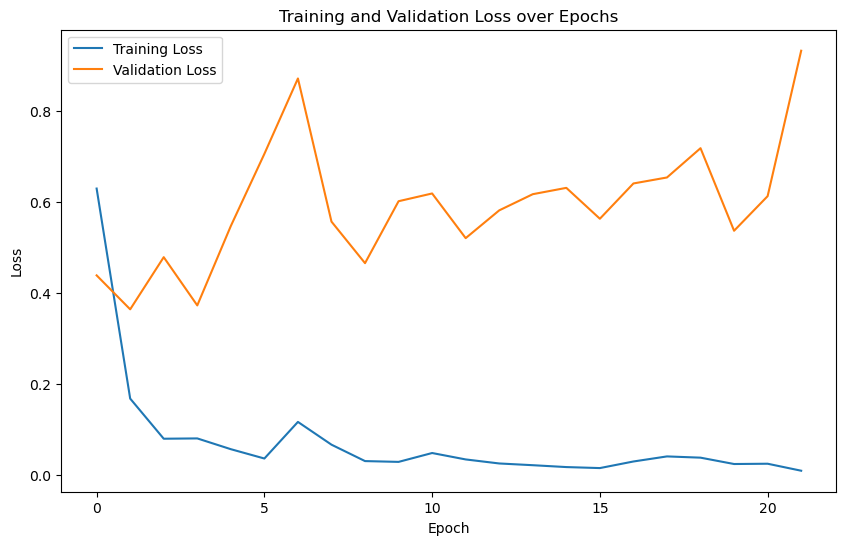

In [17]:
import matplotlib.pyplot as plt  # 导入 matplotlib.pyplot，而不是 matplotlib

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.savefig('../loss_curve_fig/merfish_human_neocortex_supervised_loss_curve.png', dpi=400)  # 保存图像为png格式，400 dpi
plt.savefig('../loss_curve_fig/merfish_human_neocortex_supervised_loss_curve.eps', format='eps', dpi=400)  # 保存图像为png格式，400 dpi

plt.show()


In [18]:
# 8. 使用 KNN 替代测试阶段的 FC 分类层
# 使用 encoder 提取训练集和测试集的 embedding
estim.model.eval()
with torch.no_grad():
    train_embeddings = estim.model.encoder(torch.tensor(X_train).float().to(device)).cpu().numpy()
    test_embeddings = estim.model.encoder(torch.tensor(X_test).float().to(device)).cpu().numpy()

In [19]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

    

    # 初始化和训练KNN分类器
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_embeddings, y_train)
    
    # 模型预测
predictions = knn.predict(test_embeddings)

    # 计算准确率和 F1 分数
accuracy = accuracy_score(y_test, predictions)
print(f"KNN Accuracy on Test Data: {accuracy}")
f1 = f1_score(y_test, predictions, average='weighted')
print(f"Weighted F1 Score: {f1}")
    
macro_f1 = f1_score(y_test, predictions, average='macro')
print(f'Macro F1 Score: {macro_f1}')

    # 计算随机猜测的准确率
class_probabilities = np.bincount(y_test) / len(y_test)
random_accuracy = np.sum(class_probabilities ** 2)
print(f"Random Guess Accuracy: {random_accuracy}")

    # 生成分类报告
report = classification_report(y_test, predictions, target_names=label_encoder.classes_)
print(report)

KNN Accuracy on Test Data: 0.9101723719349356
Weighted F1 Score: 0.9095466236804831
Macro F1 Score: 0.8881261461462555
Random Guess Accuracy: 0.08554398369790313
                         precision    recall  f1-score   support

                B Cells       0.94      0.92      0.93       219
           CD4+ T Cells       0.87      0.93      0.90       392
           CD8+ T Cells       0.88      0.85      0.86       281
                 DCIS 1       0.95      0.96      0.96       293
                 DCIS 2       0.91      0.96      0.94       326
            Endothelial       0.97      0.95      0.96       154
              IRF7+ DCs       0.90      0.85      0.88        33
         Invasive Tumor       0.92      0.93      0.93       701
             LAMP3+ DCs       0.89      0.84      0.86        19
          Macrophages 1       0.93      0.93      0.93       425
          Macrophages 2       0.89      0.92      0.91       106
             Mast Cells       1.00      0.85      0.92   

In [20]:
with torch.no_grad():
    new_data_tensor = torch.tensor(new_data).float().to(device)
    SSL_embeddings = estim.model.encoder(new_data_tensor).detach().cpu().numpy()
new_adata = sc.read_h5ad(data_dir)
new_adata.obsm[f'supervised_{random_seed}'] = SSL_embeddings
new_adata.uns[f'supervised_y_test_{random_seed}'] = y_test
new_adata.uns[f'supervised_predictions_{random_seed}'] = predictions
new_adata.uns[f'supervised_target_names_{random_seed}'] = label_encoder.classes_
new_adata.uns[f'supervised_train_loss_{random_seed}'] = train_losses
new_adata.uns[f'supervised_val_loss_{random_seed}'] = val_losses
new_adata.write_h5ad(data_dir)

/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [21]:

import pandas as pd
import os
import re

# 当前 Notebook 文件名
notebook_name = "chromium_breast_cancer_supervised_42.ipynb"

# 初始化需要打印的值
init_train_loss = train_losses[0] if 'train_losses' in globals() else None
init_val_loss = val_losses[0] if 'val_losses' in globals() else None
converged_epoch = len(train_losses) - patience if 'train_losses' in globals() else None
converged_val_loss = best_val_loss if 'best_val_loss' in globals() else None

# 打印所有所需的指标
print("Metrics Summary:")
if 'train_losses' in globals():
    print(f"init_train_loss\tinit_val_loss\tconverged_epoch\tconverged_val_loss\tmacro_f1\tweighted_f1\tmicro_f1")
    print(f"{init_train_loss:.3f}\t{init_val_loss:.3f}\t{converged_epoch}\t{converged_val_loss:.3f}\t{macro_f1:.3f}\t{f1:.3f}\t{accuracy:.3f}")
else:
    print(f"macro_f1\tweighted_f1\tmicor_f1")
    print(f"{macro_f1:.3f}\t{f1:.3f}\t{accuracy:.3f}")

# 保存结果到 CSV 文件
output_data = {
    'dataset_split_random_seed': [int(random_seed)],
    'dataset': ['chromium_breast_cancer'],
    'method': [re.search(r'breast_cancer_(.*?)_\d+', notebook_name).group(1)],
    'init_train_loss': [init_train_loss if init_train_loss is not None else ''],
    'init_val_loss': [init_val_loss if init_val_loss is not None else ''],
    'converged_epoch': [converged_epoch if converged_epoch is not None else ''],
    'converged_val_loss': [converged_val_loss if converged_val_loss is not None else ''],
    'macro_f1': [macro_f1],
    'weighted_f1': [f1],
    'micor_f1': [accuracy]
}
output_df = pd.DataFrame(output_data)

# 保存到当前目录下名为 results 的文件夹中
if not os.path.exists('results'):
    os.makedirs('results')

csv_filename = f"results/{os.path.splitext(notebook_name)[0]}_results.csv"
output_df.to_csv(csv_filename, index=False)


Metrics Summary:
init_train_loss	init_val_loss	converged_epoch	converged_val_loss	macro_f1	weighted_f1	micro_f1
0.630	0.439	2	0.364	0.888	0.910	0.910
